In [1]:
import sys
sys.path.append("./tacotron2/") # go to parent dir
# from customFunctions import *
sys.path.append("./waveglow/")

In [2]:
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd



In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', 
                       interpolation='none')

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.training_files = './tacotron2/filelists/vlsp/train.txt'

attention_dim: 128
attention_location_kernel_size: 31
attention_location_n_filters: 32
attention_rnn_dim: 1024
batch_size: 16
cudnn_benchmark: false
cudnn_enabled: true
decoder_rnn_dim: 1024
dist_backend: nccl
dist_url: tcp://localhost:54321
distributed_run: false
dynamic_loss_scaling: true
encoder_embedding_dim: 512
encoder_kernel_size: 5
encoder_n_convolutions: 3
epochs: 37
filter_length: 1024
fp16_run: false
gate_threshold: 0.5
grad_clip_thresh: 1.0
hop_length: 256
ignore_layers:
- embedding.weight
iters_per_checkpoint: 200
learning_rate: 0.001
load_mel_from_disk: false
mask_padding: true
max_decoder_steps: 1000
max_wav_value: 32768.0
mel_fmax: 8000.0
mel_fmin: 0.0
n_frames_per_step: 1
n_mel_channels: 80
n_symbols: 150
p_attention_dropout: 0.1
p_decoder_dropout: 0.1
postnet_embedding_dim: 512
postnet_kernel_size: 5
postnet_n_convolutions: 5
prenet_dim: 256
sampling_rate: 22050
seed: 1234
symbols_embedding_dim: 512
text_cleaners:
- flowtron_cleaners
training_files: filelists/vlsp/tra

In [5]:
checkpoint_path = "./tacotron2/checkpoints/checkpoint_52846"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [6]:
from waveglow.denoiser import Denoiser
waveglow_path = './waveglow/checkpoints/waveglow_62206'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
waveglow = waveglow.remove_weightnorm(waveglow)
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [7]:
from data_utils import TextMelLoader, TextMelCollate
trainset = TextMelLoader(hparams.training_files, hparams)

In [22]:
textx = "bề cao và bề ngang tương xứng với nhau #"


#

1. 1.000000003 - 1.000  
2. ngày tháng ( 
3. 

ONNX


In [23]:
inputs=trainset.get_text(
    textx
)
sequence = torch.autograd.Variable(
    inputs.unsqueeze(0)).cuda().long()
sequence.size()
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

In [24]:
sequence

tensor([[24, 36,  0, 25,  6, 52,  0, 87,  8,  0, 24, 36,  0, 51, 40,  6, 51, 40,
          0, 74, 81, 64, 51, 40,  0, 88, 82, 51, 40,  0, 87, 65, 42,  0, 51, 41,
          6, 75,  0, 99]], device='cuda:0')

In [25]:
# mel_outputs, mel_outputs_postnet, _, alignments

In [26]:
# trainset.text_embedding.symbol2numeric_dict
sequence.size()

torch.Size([1, 40])

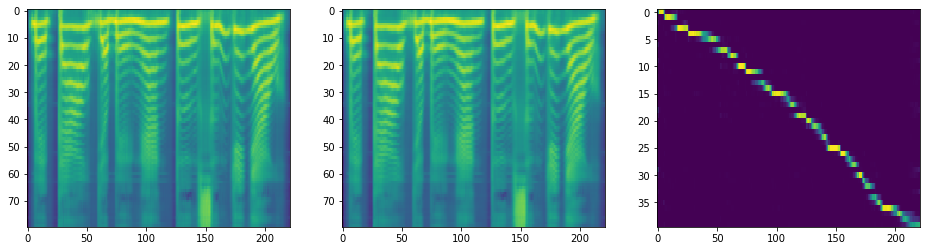

In [27]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [28]:
z=torch.mean(mel_outputs_postnet[0], dim=1).detach().cpu().numpy()
z

array([-3.57 , -3.354, -3.154, -2.082, -1.075, -0.808, -1.391, -2.143,
       -2.586, -2.664, -2.691, -2.816, -2.795, -2.7  , -2.756, -2.98 ,
       -3.088, -3.295, -3.498, -3.518, -3.496, -3.54 , -3.787, -4.01 ,
       -4.168, -4.11 , -3.97 , -3.883, -4.14 , -4.457, -4.54 , -4.363,
       -4.168, -4.27 , -4.54 , -4.535, -4.496, -4.473, -4.508, -4.613,
       -4.68 , -4.742, -4.805, -4.81 , -4.84 , -4.81 , -4.83 , -4.855,
       -4.883, -4.902, -4.85 , -4.746, -4.69 , -4.645, -4.574, -4.594,
       -4.613, -4.793, -4.99 , -5.04 , -4.94 , -5.016, -4.98 , -5.152,
       -5.59 , -5.598, -5.65 , -5.8  , -5.965, -6.03 , -5.97 , -5.93 ,
       -5.863, -5.945, -5.844, -5.69 , -5.543, -5.633, -5.703, -5.77 ],
      dtype=float16)

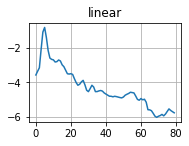

In [29]:
plt.subplot(221)
plt.plot(np.arange(z.shape[0]), z)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)

In [30]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet,sigma=0.6)
# with torch.no_grad():
#     audio = waveglow.infer(z.unsqueeze(0).float().to("cuda").half(),sigma=1.)

In [31]:
# from waveglow.mel2samp import load_wav_to_torch
# z = load_wav_to_torch("./tacotron2/filelists/vlsp/wavs_train/07271.wav")
# au= z[0] / 32768.0
# print(au.size())

# with torch.no_grad():
#     ax = torch.autograd.Variable(au.cuda())
#     audio = waveglow((mel_outputs_postnet,ax))

In [32]:
# audio.half()
waveglow.n_remaining_channels, mel_outputs_postnet.size(2),audio.size()

(4, 221, torch.Size([1, 56576]))

In [33]:
388 * 4

1552

In [34]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
a = np.array(audio_denoised[0].data.cpu().numpy())


In [35]:
ipd.Audio(a, rate=hparams.sampling_rate, autoplay=False)

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import librosa
import IPython.display as ipd
a = np.array(audio[0].data.cpu().numpy())

a,index = librosa.effects.trim(a, top_db=40)
# ipd.Audio(a, rate=hparams.sampling_rate)

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
a = np.array(audio_denoised[0].data.cpu().numpy())

a,index = librosa.effects.trim(a, top_db=40)
ipd.Audio(a, rate=hparams.sampling_rate)

In [22]:
z=trainset.get_mel("./tacotron2/filelists/vlsp/wavs_train/07271.wav")

In [31]:
from waveglow.mel2samp import load_wav_to_torch
z = load_wav_to_torch("./tacotron2/filelists/vlsp/wavs_train/07271.wav")
audio = z[0] / 32768.0
audio

tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0001, -0.0001, -0.0003])

In [ ]:
from scipy.io.wavfile import write
# normalize audio for now
a = a/ np.abs(a).max()
# a = a[:hparams['sampling_rate'] * 3]
import os
write("./out.wav", hparams['sampling_rate'], a)

In [ ]:
a.astype(np.int16)

In [ ]:
librosa.output.write_wav('file_trim_5s.wav', a,hparams['sampling_rate'])

In [ ]:
hparams['sampling_rate']

In [ ]:
z=trainset.get_mel("./tacotron2/filelists/vlsp/wavs_train/07271.wav")

In [ ]:
z.unsqueeze(0).float().to("cuda")

In [ ]:
z -mel_outputs_postnet.squeeze(0)

In [ ]:
mel_outputs_postnet.size(),z.size()

In [ ]:
torch.mean(mel_outputs_postnet[0,:,:341].cpu() - z.cpu())

In [ ]:
torch.exp(z)